(heavy_tail)=
# Heavy-Tailed Distributions

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install --upgrade yfinance quantecon pandas_datareader interpolation

We use the following imports.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm

from interpolation import interp
from pandas_datareader import wb
from scipy.stats import norm, cauchy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Overview

In this section we give some motivation for the lecture.

### Introduction: light tails

Most commonly used probability distributions in classical statistics and
the natural sciences have "light tails."

To explain this concept, let's look first at examples.

The classic example is the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), which has density

$$ 
    f(x) = \frac{1}{\sqrt{2\pi}\sigma} 
    \exp\left( -\frac{(x-\mu)^2}{2 \sigma^2} \right)
    \qquad
    (-\infty < x < \infty)
$$


The two parameters $\mu$ and $\sigma$ are the mean and standard deviation
respectively.

As $x$ deviates from $\mu$, the value of $f(x)$ goes to zero extremely
quickly.

We can see this when we plot the density and show a histogram of observations,
as with the following code (which assumes $\mu=0$ and $\sigma=1$).

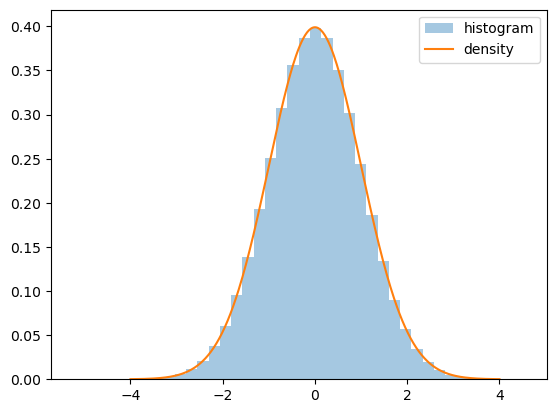

In [3]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='histogram', density=True)
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), label='density')
ax.legend()
plt.show()

Notice how 

* the density's tails converge quickly to zero in both directions and
* even with 1,000,000 draws, we get no very large or very small observations.

We can see the last point more clearly by executing

In [4]:
X.min(), X.max()

(-5.240875891940666, 4.5360025858257655)

Here's another view of draws from the same distribution:

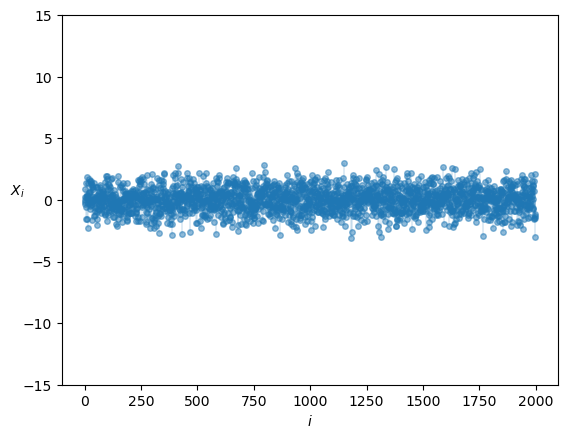

In [5]:
n = 2000
fig, ax = plt.subplots()
data = norm.rvs(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_ylim(-15, 15)
ax.set_xlabel('$i$')
ax.set_ylabel('$X_i$', rotation=0)
plt.show()

We have plotted each individual draw $X_i$ against $i$.

None are very large or very small.

In other words, extreme observations are rare and draws tend not to deviate
too much from the mean.

Putting this another way, light-tailed distributions are those that
rarely generate extreme values.

(A more formal definition is given below.)

Many statisticians and econometricians 
use rules of thumb such as "outcomes more than four or five
standard deviations from the mean can safely be ignored."

But this is only true when distributions have light tails...


### When are light tails valid?

In probability theory and in the real world, many distributions are
light-tailed.

For example, human height is light-tailed.

Yes, it's true that we see some very tall people.

* For example, basketballer [Sun Mingming](https://en.wikipedia.org/wiki/Sun_Mingming) is 2.32 meters tall

But have you ever heard of someone who is 20 meters tall?  Or 200?  Or 2000? 

Have you ever wondered why not? 

After all, there are 8 billion people in the world!

In essence, the reason we don't see such draws is that the distribution of
human high has very light tails.

In fact human height is approximately normally distributed.


### Returns on assets


But now we have to ask: does economic data always look like this?

Let's look at some financial data first.

Our aim is to plot the daily change in the price of Amazon (AMZN) stock for
the period from 1st January 2015 to 1st July 2022.

This equates to daily returns if we set dividends aside.

The code below produces the desired plot using Yahoo financial data via the `yfinance` library.

[*********************100%***********************]  1 of 1 completed


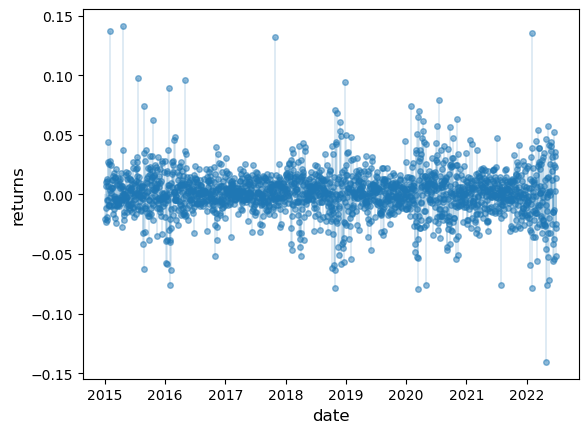

In [6]:
s = yf.download('AMZN', '2015-1-1', '2022-7-1')['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

This data looks different to the draws from the normal distribution.

Several of observations are quite extreme.

We get a similar picture if we look at other assets, such as Bitcoin

[*********************100%***********************]  1 of 1 completed


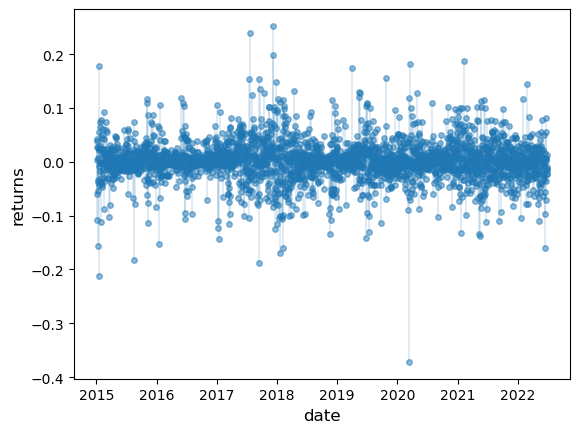

In [7]:
s = yf.download('BTC-USD', '2015-1-1', '2022-7-1')['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

The histogram also looks different to the histogram of the normal
distribution:

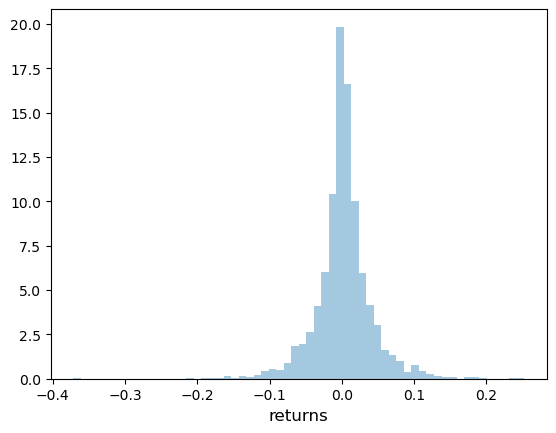

In [8]:
fig, ax = plt.subplots()
ax.hist(r, bins=60, alpha=0.4, label='bitcoin returns', density=True)
ax.set_xlabel('returns', fontsize=12)
plt.show()

If we look at higher frequency returns data (e.g., tick-by-tick), we often see 
even more extreme observations.

See, for example, {cite}`mandelbrot1963variation` or {cite}`rachev2003handbook`.


### Other data

The data we have just seen is said to be "heavy-tailed".

With heavy-tailed distributions, extreme outcomes occur relatively
frequently.

Importantly, there are many examples of heavy-tailed distributions
observed in economic and financial settings!

For example, the income and the wealth distributions are heavy-tailed 

* You can imagine this: most people have low or modest wealth but some people
  are extremely rich.

The firm size distribution is also heavy-tailed 

* You can imagine this too: most firms are small but some firms are enormous.

The distribution of town and city sizes is heavy-tailed 

* Most towns and cities are small but some are very large.

Later in this lecture, we examine heavy tails in these distributions.

### Why should we care?

Heavy tails are common in economic data but does that mean they are important?

The answer to this question is affirmative!

When distributions are heavy-tailed, we need to think carefully about issues
like

* diversification and risk
* forecasting
* taxation (across a heavy-tailed income distribution), etc.

We return to these points below.






## Visual comparisons

Later we will provide a mathematical definition of the difference between
light and heavy tails.

But for now let's do some visual comparisons to help us build intuition on the
difference between these two types of distributions.


### Simulations

The figure below shows a simulation.  

The top two subfigures each show 120 independent draws from the normal
distribution, which is light-tailed.

The bottom subfigure shows 120 independent draws from [the Cauchy
distribution](https://en.wikipedia.org/wiki/Cauchy_distribution), which is
heavy-tailed.

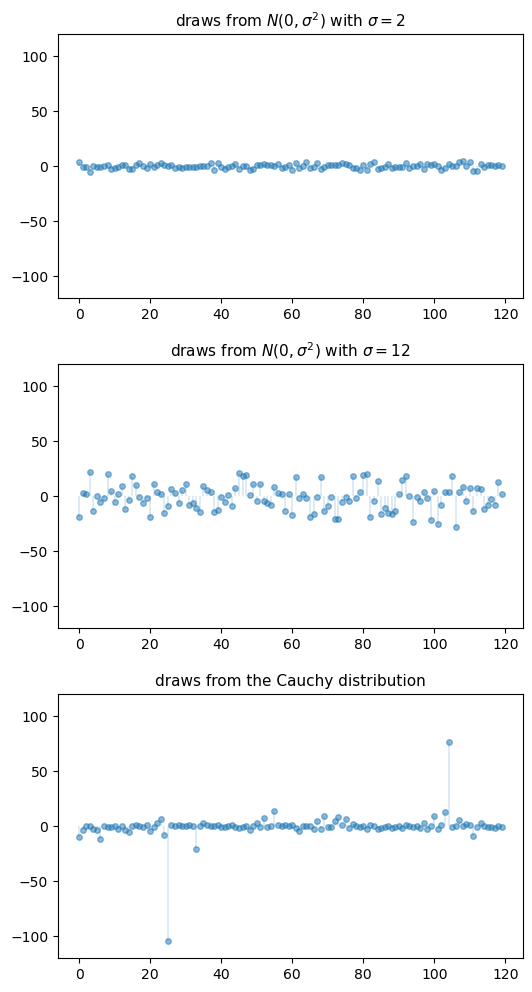

In [9]:
n = 120
np.random.seed(11)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((-120, 120))

s_vals = 2, 12

for ax, s in zip(axes[:2], s_vals):
    data = np.random.randn(n) * s
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"draws from $N(0, \sigma^2)$ with $\sigma = {s}$", fontsize=11)

ax = axes[2]
distribution = cauchy()
data = distribution.rvs(n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_title(f"draws from the Cauchy distribution", fontsize=11)

plt.subplots_adjust(hspace=0.25)

plt.show()

In the top subfigure, the standard deviation of the normal distribution is 2,
and the draws are clustered around the mean.

In the middle subfigure, the standard deviation is increased to 12 and, as
expected, the amount of dispersion rises.

The bottom subfigure, with the Cauchy draws, shows a different pattern: tight
clustering around the mean for the great majority of observations, combined
with a few sudden large deviations from the mean.

This is typical of a heavy-tailed distribution.


### Nonnegative distributions

Let's compare some distributions that only take nonnegative values.

One is the exponential distribution, which we discussed in {doc}`our lecture
on probability and distributions <prob_dist>`.

The exponential distribution is a light-tailed distribution.

Here are some draws from the exponential distribution.

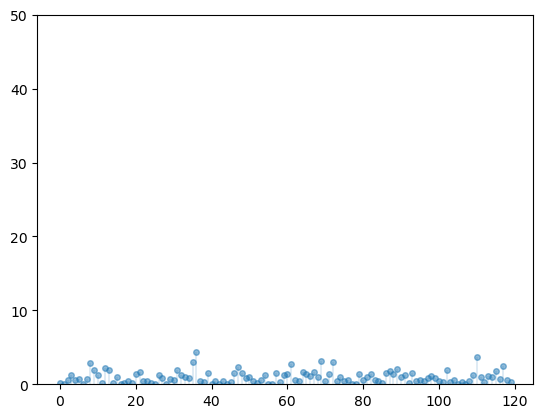

In [10]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 50))

data = np.random.exponential(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)

plt.show()

Another nonnegative distribution is the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution). 

If $X$ has the Pareto distribution, then there are positive constants $\bar x$
and $\alpha$ such that

```{math}
:label: pareto

\mathbb P\{X > x\} =
\begin{cases}
    \left( \bar x/x \right)^{\alpha}
        & \text{ if } x \geq \bar x
    \\
    1
        & \text{ if } x < \bar x
\end{cases}
```

The parameter $\alpha$ is called the **tail index** and $\bar x$ is called the
**minimum**.

The Pareto distribution is a heavy-tailed distribution.

One way that the Pareto distribution arises is as the exponential of an
exponential random variable.

In particular, if $X$ is exponentially distributed with rate parameter $\alpha$, then

$$   Y = \bar x \exp(X) $$

is Pareto-distributed with minimum $\bar x$ and tail index $\alpha$. 

Here are some draws from the Pareto distribution with tail index $1$ and minimum
$1$.

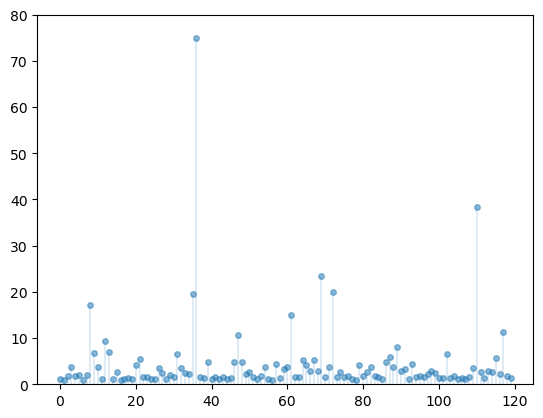

In [11]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 80))
exponential_data = np.random.exponential(size=n)
pareto_data = np.exp(exponential_data)
ax.plot(list(range(n)), pareto_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, pareto_data, lw=0.2)

plt.show()

Notice how extreme outcomes are more common.

### Counter CDFs

For nonnegative random varialbes, one way to visualize the difference between
light and heavy tails is to look at the 
**counter CDF** (CCDF).

For a random variable $X$ with CDF $F$, the CCDF is the function 

$$ G(x) := 1 - F(x) = \mathbb P\{X > x\} $$

(Some authors call $G$ the "survival" function.)

The CCDF shows how fast the upper tail goes to zero as $x \to \infty$.

If $X$ is exponentially distributed with rate parameter $\alpha$, then the CCDF is

$$ G_E(x) = \exp(- \alpha x) $$

This function goes to zero relatively quickly as $x$ gets large.

The Pareto distribution has CCDF

$$ G_P(x) = x^{- \alpha} $$

This function goes to zero as $x \to \infty$, but much slower than $G_E$.

Here's a plot that illustrates how $G_E$ goes to zero faster that $G_P$.

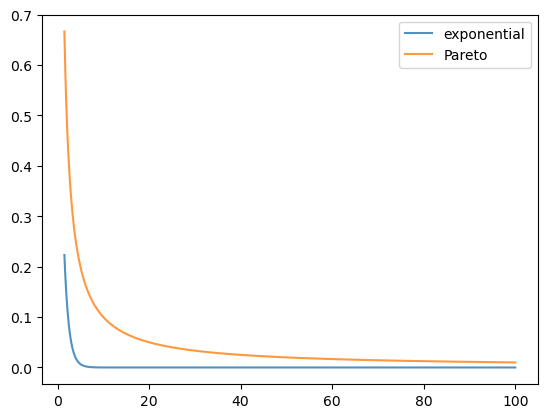

In [12]:
x = np.linspace(1.5, 100, 1000)
fig, ax = plt.subplots()
alpha = 1.0
ax.plot(x, np.exp(- alpha * x), label='exponential', alpha=0.8)
ax.plot(x, x**(- alpha), label='Pareto', alpha=0.8)
ax.legend()
plt.show()

Here's a log-log plot of the same functions, which makes visual comparison a
bit easier.

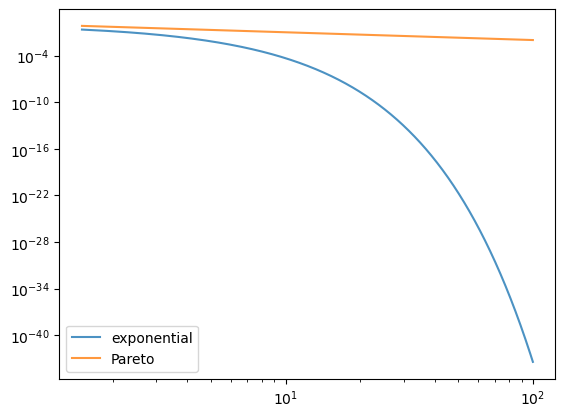

In [13]:
fig, ax = plt.subplots()
alpha = 1.0
ax.loglog(x, np.exp(- alpha * x), label='exponential', alpha=0.8)
ax.loglog(x, x**(- alpha), label='Pareto', alpha=0.8)
ax.legend()
plt.show()

In the log-log plot, the Pareto CCDF is linear, while the exponential one is
concave.

This idea is often used to separate light- and heavy-tailed distributions in
visualations --- we return to this point below.


### Empirical CCDFs

The sample countpart of the CCDF function is the **empirical CCDF**.

Given a sample $x_1, \ldots, x_n$, the empirical CCDF is given by

$$ \hat G(x) = \frac{1}{n} \sum_{i=1}^n \mathbb 1\{x_i > x\} $$

Thus, $\hat G(x)$ shows the fraction of the sample that exceeds $x$.

Here's a figure containing some empirical CCDFs from simulated data.

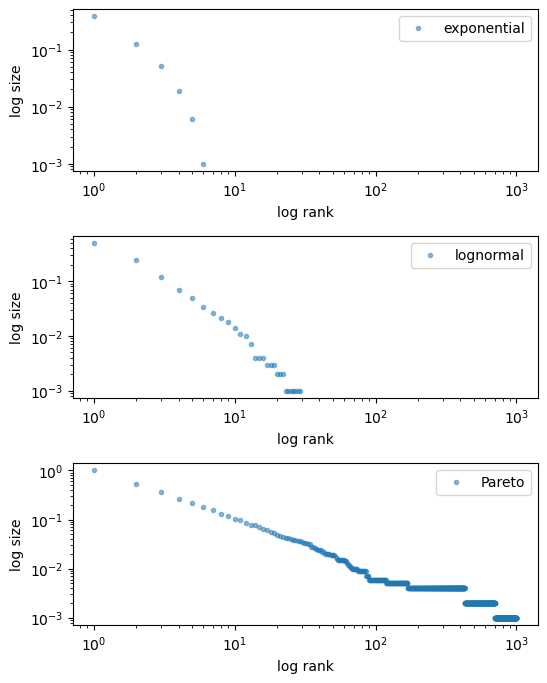

In [14]:
def eccdf(x, data):
    "Simple empirical CCDF function."
    return np.mean(data > x)

x_grid = np.linspace(1, 1000, 1000)
sample_size = 1000
np.random.seed(13)
z = np.random.randn(sample_size)

data_1 = np.random.exponential(size=sample_size)
data_2 = np.exp(z)
data_3 = np.exp(np.random.exponential(size=sample_size))

data_list = [data_1, data_2, data_3]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()
labels = ['exponential', 'lognormal', 'Pareto']

for data, label, ax in zip(data_list, labels, axes):

    ax.loglog(x_grid, [eccdf(x, data) for x in x_grid], 
        'o', markersize=3.0, alpha=0.5, label=label)
    ax.set_xlabel("log rank")
    ax.set_ylabel("log size")

    ax.legend()

fig.subplots_adjust(hspace=0.4)

plt.show()

As with the CCDF, the empirical CCDF from the Pareto distributions is 
approximately linear in a log-log plot.

We will use this idea below when we look at real data.


### Power laws 


One specific class of heavy-tailed distributions has been found repeatedly in
economic and social phenomena: the class of so-called power laws.

A random variable $X$ is said to have a **power law** if, for some $\alpha > 0$,

```{math}
\mathbb P\{X > x\} \approx  x^{-\alpha}
\quad \text{when $x$ is large}
```
We can write this more mathematically as

```{math}
:label: plrt

\lim_{x \to \infty} x^\alpha \, \mathbb P\{X > x\} = c
\quad \text{for some $c > 0$}
```

It is also common to say that a random variable $X$ with this property
has a **Pareto tail** with **tail index** $\alpha$ if

Notice that every Pareto distribution with tail index $\alpha$ 
has a **Pareto tail** with **tail index** $\alpha$.

We can think of power laws as a generalization of Pareto distributions.

They are distributions that resemble Pareto distributions in their upper right
tail.

Another way to think of power laws is a set of distributions with a specific
kind of (very) heavy tail.

## Heavy tails in economic cross-sections

As mentioned above, heavy tails are pervasive in economic data.

In fact power laws seem to be very common as well.

We now illustrate this by showing the empirical CCDF of 

All plots are in log-log, so that a power law shows up as a linear log-log
plot, at least in the upper tail.

We hide the code that generates the figures, which is somewhat complex, but
readers are of course welcome to explore the code (perhaps after examining the figures).

In [15]:
def empirical_ccdf(data, 
                   ax, 
                   aw=None,   # weights
                   label=None,
                   xlabel=None,
                   add_reg_line=False, 
                   title=None):
    """
    Take data vector and return prob values for plotting.
    Upgraded empirical_ccdf
    """
    y_vals = np.empty_like(data, dtype='float64')
    p_vals = np.empty_like(data, dtype='float64')
    n = len(data)
    if aw is None:
        for i, d in enumerate(data):
            # record fraction of sample above d
            y_vals[i] = np.sum(data >= d) / n
            p_vals[i] = np.sum(data == d) / n
    else:
        fw = np.empty_like(aw, dtype='float64')
        for i, a in enumerate(aw):
            fw[i] = a / np.sum(aw)
        pdf = lambda x: interp(data, fw, x)
        data = np.sort(data)
        j = 0
        for i, d in enumerate(data):
            j += pdf(d)
            y_vals[i] = 1- j

    x, y = np.log(data), np.log(y_vals)
    
    results = sm.OLS(y, sm.add_constant(x)).fit()
    b, a = results.params
    
    kwargs = [('alpha', 0.3)]
    if label:
        kwargs.append(('label', label))
    kwargs = dict(kwargs)

    ax.scatter(x, y, **kwargs)
    if add_reg_line:
        ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"slope = ${a: 1.2f}$")
    if not xlabel:
        xlabel='log value'
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("log prob.", fontsize=12)
        
    if label:
        ax.legend(loc='lower left', fontsize=12)
        
    if title:
        ax.set_title(title)
        
    return np.log(data), y_vals, p_vals

In [16]:
def extract_wb(varlist=['NY.GDP.MKTP.CD'], 
               c='all_countries', 
               s=1900, 
               e=2021, 
               varnames=None):
    if c == "all_countries":
        # Keep countries only (no aggregated regions)
        countries = wb.get_countries()
        countries_name = countries[countries['region'] != 'Aggregates']['name'].values
        c = "all"
    
    df = wb.download(indicator=varlist, country=c, start=s, end=e).stack().unstack(0).reset_index()
    df = df.drop(['level_1'], axis=1).transpose()
    if varnames is not None:
        df.columns = varnames
        df = df[1:]
    return df

### Firm size

Here is a plot of the firm size distribution taken from Forbes Global 2000.

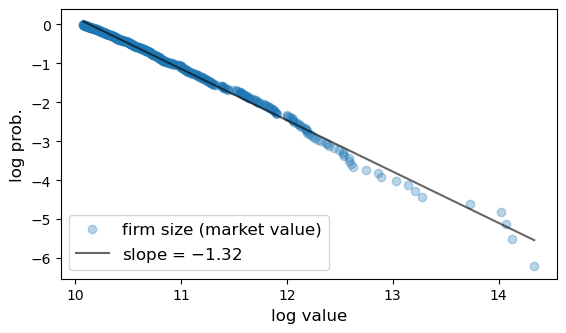

In [17]:
df_fs = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/update_csdata/cross_section/forbes-global2000.csv')
df_fs = df_fs[['Country', 'Sales', 'Profits', 'Assets', 'Market Value']]
fig, ax = plt.subplots(figsize=(6.4, 3.5))

label="firm size (market value)"
d = df_fs.sort_values('Market Value', ascending=False)
empirical_ccdf(np.asarray(d['Market Value'])[0:500], ax, label=label, add_reg_line=True)

plt.show()

### City size

Here is a plot of the city size distribution for the US, where size is
measured by population.

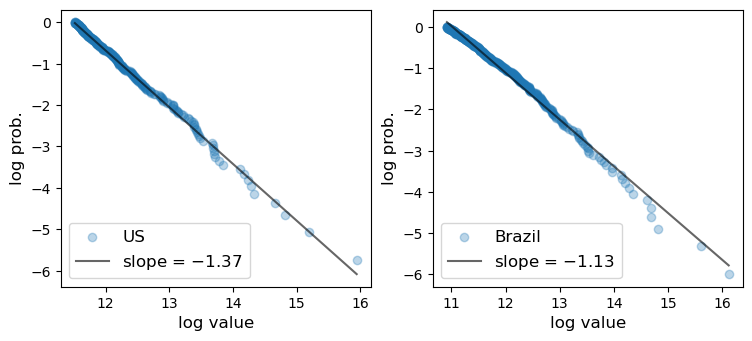

In [18]:
df_cs_us = pd.read_csv('https://raw.githubusercontent.com/QuantEcon/high_dim_data/update_csdata/cross_section/cities_us.txt', delimiter="\t", header=None)
df_cs_us = df_cs_us[[0, 3]]
df_cs_us.columns = 'rank', 'pop'
x = np.asarray(df_cs_us['pop'])
citysize = []
for i in x:
    i = i.replace(",", "")
    citysize.append(int(i))
df_cs_us['pop'] = citysize
df_cs_br = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/update_csdata/cross_section/cities_brazil.csv', delimiter=",", header=None)
df_cs_br.columns = df_cs_br.iloc[0]
df_cs_br = df_cs_br[1:401]
df_cs_br = df_cs_br.astype({"pop2023": float})

fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))
empirical_ccdf(np.asarray(df_cs_us['pop']), axes[0], label="US", add_reg_line=True)
empirical_ccdf(np.asarray(df_cs_br['pop2023']), axes[1], label="Brazil", add_reg_line=True)

plt.show()

### Wealth

Here is a plot of the upper tail of the wealth distribution.

The data is from the Forbes billionaires list.

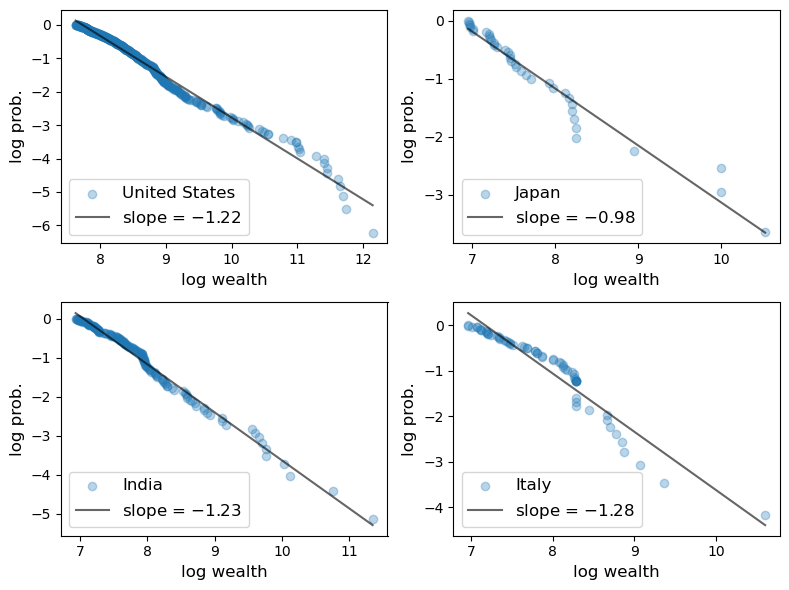

In [19]:
df_w = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/update_csdata/cross_section/forbes-billionaires.csv')
df_w = df_w[['country', 'realTimeWorth', 'realTimeRank']].dropna()
df_w = df_w.astype({'realTimeRank': int})
df_w = df_w.sort_values('realTimeRank', ascending=True).copy()
countries = ['United States', 'Japan', 'India', 'Italy']  
N = len(countries)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, c in enumerate(countries):
    df_w_c = df_w[df_w['country'] == c].reset_index()
    z = np.asarray(df_w_c['realTimeWorth'])
    # print('number of the global richest 2000 from '+ c, len(z))
    if len(z) <= 500:    # cut-off number: top 500
        z = z[0:500]

    empirical_ccdf(z[0:500], axs[i], label=c, xlabel='log wealth', add_reg_line=True)
    
fig.tight_layout()

plt.show()

### GDP

Of course, not all cross-sectional distributions are heavy-tailed.

Here we show cross-country per capita GDP.

In [20]:
# get gdp and gdp per capita for all regions and countries in 2021

variable_code = ['NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']
variable_names = ['GDP', 'GDP per capita']

df_gdp1 = extract_wb(varlist=variable_code, 
                     c="all_countries", 
                     s="2021", 
                     e="2021", 
                     varnames=variable_names)

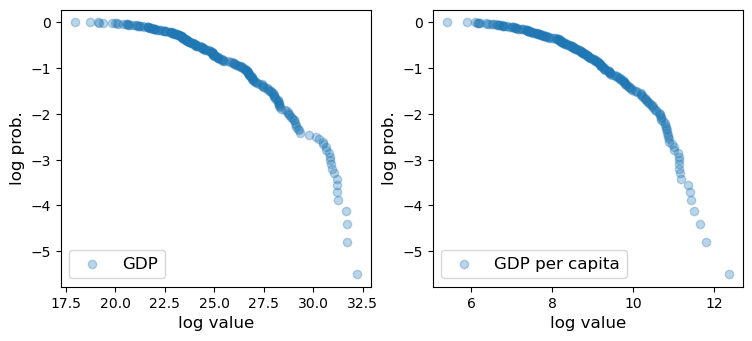

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

for name, ax in zip(variable_names, axes):
    empirical_ccdf(np.asarray(df_gdp1[name]).astype("float64"), ax, add_reg_line=False, label=name)

plt.show()

The plot is concave rather than linear, so the distribution has light tails.

One reason is that this is data on an aggregate variable, which involves some
averaging in its definition.

Averaging tends to eliminate extreme outcomes.


## Failure of the LLN

One impact of heavy tails is that sample averages can be poor estimators of
the underlying mean of the distribution.

To understand this point better, recall {doc}`our earlier discussion <lln_clt>` 
of the Law of Large Numbers, which considered IID $X_1, \ldots, X_n$ with common distribution $F$

If $\mathbb E |X_i|$ is finite, then
the sample mean $\bar X_n := \frac{1}{n} \sum_{i=1}^n X_i$ satisfies

```{math}
:label: lln_as2

\mathbb P \left\{ \bar X_n \to \mu \text{ as } n \to \infty \right\} = 1
```

where $\mu := \mathbb E X_i = \int x F(dx)$ is the common mean of the sample.

The condition $\mathbb E | X_i | = \int |x| F(dx) < \infty$ holds
in most cases but can fail if the distribution $F$ is very heavy tailed.

For example, it fails for the Cauchy distribution.

Let's have a look at the behavior of the sample mean in this case, and see
whether or not the LLN is still valid.

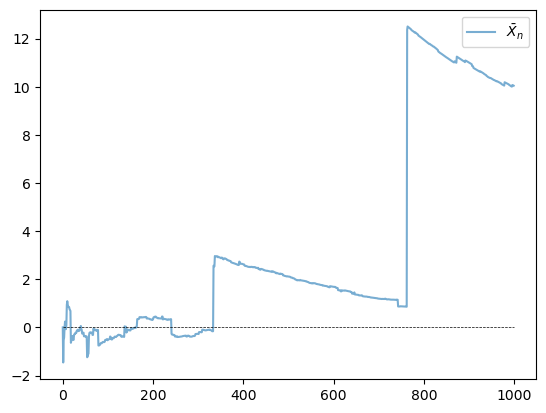

In [22]:
from scipy.stats import cauchy

np.random.seed(1234)
N = 1_000

distribution = cauchy()

fig, ax = plt.subplots()
data = distribution.rvs(N)

# Compute sample mean at each n
sample_mean = np.empty(N)
for n in range(1, N):
    sample_mean[n] = np.mean(data[:n])

# Plot
ax.plot(range(N), sample_mean, alpha=0.6, label='$\\bar{X}_n$')

ax.plot(range(N), np.zeros(N), 'k--', lw=0.5)
ax.legend()

plt.show()

The sequence shows no sign of converging.

We return to this point in the exercises.


## Why do heavy tails matter?

We have now seen that 

1. heavy tails are frequent in economics and
2. the Law of Large Numbers fails when tails are very heavy.

But what about in the real world?  Do heavy tails matter?

Let's briefly discuss why they do.


### Diversification

One of the most important ideas in investing is using diversification to
reduce risk.

This is a very old idea --- consider, for example, the expression "don't put all your eggs in one basket".

To illustrate, consider an investor with one dollar of wealth and a choice over
$n$ assets with payoffs $X_1, \ldots, X_n$.  

Suppose that returns on distinct  assets are
independent and each return has  mean $\mu$ and variance $\sigma^2$.

If the investor puts all wealth in one asset, say, then the expected payoff of the
portfolio is $\mu$ and the variance is $\sigma^2$.  

If instead the investor puts share $1/n$ of her wealth in each asset, then the portfolio payoff is

$$ Y_n = \sum_{i=1}^n \frac{X_i}{n} = \frac{1}{n} \sum_{i=1}^n X_i. $$  

Try computing the mean and variance.

You will find that

* The mean is unchanged at $\mu$, while 
* the variance of the portfolio has fallen to $\sigma^2 / n$.

Diversification reduces risk, as expected.

But there is a hidden assumption here: the variance is of returns is finite.

If the distribution is heavy-tailed and the variance is infinite, then this
logic is incorrect.

For example, we saw above that if every $X_i$ is Cauchy, then so is $Y_n$.

This means that diversification doesn't help at all!


### Fiscal policy

The heaviness of the tail in the wealth distribution matters for taxation and redistribution policies.

The same is true for the income distribution.

For example, the heaviness of the tail of the income distribution helps
determine how much revenue a given tax policy will raise.




(cltail)=
## Classifying tail properties

Up until now we have discussed light and heavy tails without any mathematical
definitions.

Let's now rectify this.

We will focus our attention on the right hand tails of
nonnegative random variables and their distributions.

The definitions for
left hand tails are very similar and we omit them to simplify the exposition.

### Light and heavy tails

A distribution $F$ with density $f$ on $\mathbb R_+$ is called **heavy-tailed** if

```{math}
:label: defht

\int_0^\infty \exp(tx) f(x) dx = \infty \; \text{ for all } t > 0.
```

We say that a nonnegative random variable $X$ is **heavy-tailed** if its density is heavy-tailed.

This is equivalent to stating that its **moment generating function** $m(t) :=
\mathbb E \exp(t X)$ is infinite for all $t > 0$.

For example, the [log-normal
distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) is
heavy-tailed because its moment generating function is infinite everywhere on
$(0, \infty)$.

As claimed above, the Pareto distribution is also heavy-tailed.

It is easy to see that, under the Pareto law,  $\mathbb P\{X > x\}$ satisfies {eq}`plrt`.


A distribution $F$ on $\mathbb R_+$ is called **light-tailed** if it is not heavy-tailed.

A nonnegative random variable $X$ is **light-tailed** if its distribution $F$ is light-tailed.

For example, every random variable with bounded support is light-tailed. (Why?)

As another example, if $X$ has the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), with cdf $F(x) = 1 - \exp(-\lambda x)$ for some $\lambda > 0$, then its moment generating function is 

$$ m(t) = \frac{\lambda}{\lambda - t} \quad \text{when } t < \lambda $$

In particular, $m(t)$ is finite whenever $t < \lambda$, so $X$ is light-tailed.

One can show that if $X$ is light-tailed, then all of its
[moments](https://en.wikipedia.org/wiki/Moment_(mathematics)) are finite.

Conversely, if some moment is infinite, then $X$ is heavy-tailed.

The latter condition is not necessary, however.

For example, the lognormal distribution is heavy-tailed but every moment is finite.



## Further reading

For more on heavy tails in the wealth distribution, see e.g., {cite}`pareto1896cours` and {cite}`benhabib2018skewed`.

For more on heavy tails in the firm size distribution, see e.g., {cite}`axtell2001zipf`, {cite}`gabaix2016power`.

For more on heavy tails in the city size distribution, see e.g., {cite}`rozenfeld2011area`, {cite}`gabaix2016power`.

There are other important implications of heavy tails, aside from those
discussed above.

For example, heavy tails in income and wealth affect productivity growth, business cycles, and political economy.

For further reading, see, for example, {cite}`acemoglu2002political`, {cite}`glaeser2003injustice`, {cite}`bhandari2018inequality` or {cite}`ahn2018inequality`.



## Exercises


```{exercise}
:label: ht_ex2

Prove: If $X$ has a Pareto tail with tail index $\alpha$, then
$\mathbb E[X^r] = \infty$ for all $r \geq \alpha$.
```

```{solution-start} ht_ex2
:class: dropdown
```

Let $X$ have a Pareto tail with tail index $\alpha$ and let $F$ be its cdf.

Fix $r \geq \alpha$.

As discussed after {eq}`plrt`, we can take positive constants $b$ and $\bar x$ such that

$$
\mathbb P\{X > x\} \geq b x^{- \alpha} \text{ whenever } x \geq \bar x
$$

But then

$$
\mathbb E X^r = r \int_0^\infty x^{r-1} \mathbb P\{ X > x \} x
\geq
r \int_0^{\bar x} x^{r-1} \mathbb P\{ X > x \} x
+ r \int_{\bar x}^\infty  x^{r-1} b x^{-\alpha} x.
$$

We know that $\int_{\bar x}^\infty x^{r-\alpha-1} x = \infty$ whenever $r - \alpha - 1 \geq -1$.

Since $r \geq \alpha$, we have $\mathbb E X^r = \infty$.

```{solution-end}
```


```{exercise}
:label: ht_ex3

Repeat exercise 1, but replace the three distributions (two normal, one
Cauchy) with three Pareto distributions using different choices of
$\alpha$.

For $\alpha$, try 1.15, 1.5 and 1.75.

Use `np.random.seed(11)` to set the seed.
```


```{solution-start} ht_ex3
:class: dropdown
```

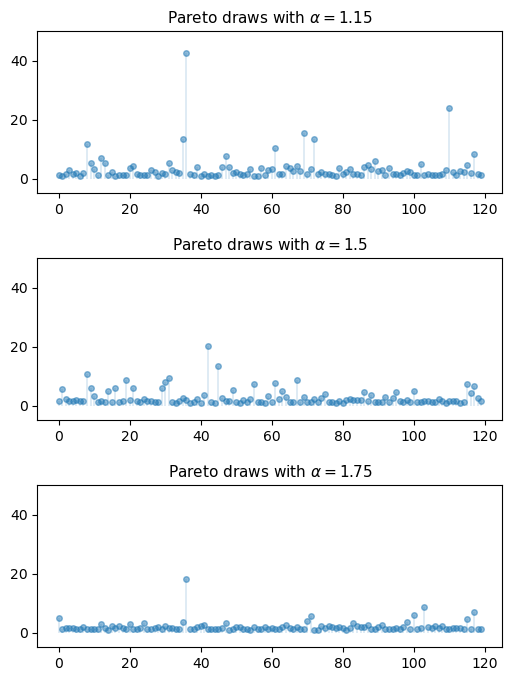

In [23]:
from scipy.stats import pareto

np.random.seed(11)

n = 120
alphas = [1.15, 1.50, 1.75]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))

for (a, ax) in zip(alphas, axes):
    ax.set_ylim((-5, 50))
    data = pareto.rvs(size=n, scale=1, b=a)
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"Pareto draws with $\\alpha = {a}$", fontsize=11)

plt.subplots_adjust(hspace=0.4)

plt.show()

```{solution-end}
```


```{exercise}
:label: ht_ex5

There is an ongoing argument about whether the firm size distribution should
be modeled as a Pareto distribution or a lognormal distribution (see, e.g.,
{cite}`fujiwara2004pareto`, {cite}`kondo2018us` or {cite}`schluter2019size`).

This sounds esoteric but has real implications for a variety of economic
phenomena.

To illustrate this fact in a simple way, let us consider an economy with
100,000 firms, an interest rate of `r = 0.05` and a corporate tax rate of
15%.

Your task is to estimate the present discounted value of projected corporate
tax revenue over the next 10 years.

Because we are forecasting, we need a model.

We will suppose that

1. the number of firms and the firm size distribution (measured in profits) remain fixed and
1. the firm size distribution is either lognormal or Pareto.

Present discounted value of tax revenue will be estimated by

1. generating 100,000 draws of firm profit from the firm size distribution,
1. multiplying by the tax rate, and
1. summing the results with discounting to obtain present value.

If $X$ has the Pareto distribution, then there are positive constants $\bar x$
and $\alpha$ such that

The Pareto distribution is assumed to take the form {eq}`pareto` with $\bar x = 1$ and $\alpha = 1.05$.

(The value the tail index $\alpha$ is plausible given the data {cite}`gabaix2016power`.)

To make the lognormal option as similar as possible to the Pareto option, choose 
its parameters such that the mean and median of both distributions are the same.

Note that, for each distribution, your estimate of tax revenue will be random 
because it is based on a finite number of draws.

To take this into account, generate 100 replications (evaluations of tax revenue) 
for each of the two distributions and compare the two samples by

* producing a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) visualizing the two samples side-by-side and
* printing the mean and standard deviation of both samples.

For the seed use `np.random.seed(1234)`.

What differences do you observe?

(Note: a better approach to this problem would be to model firm dynamics and
try to track individual firms given the current distribution.  We will discuss
firm dynamics in later lectures.)
```

```{solution-start} ht_ex5
:class: dropdown
```

To do the exercise, we need to choose the parameters $\mu$
and $\sigma$ of the lognormal distribution to match the mean and median
of the Pareto distribution.

Here we understand the lognormal distribution as that of the random variable
$\exp(\mu + \sigma Z)$ when $Z$ is standard normal.

The mean and median of the Pareto distribution {eq}`pareto` with
$\bar x = 1$ are

$$
\text{mean } = \frac{\alpha}{\alpha - 1}
\quad \text{and} \quad
\text{median } = 2^{1/\alpha}
$$

Using the corresponding expressions for the lognormal distribution leads us to
the equations

$$
\frac{\alpha}{\alpha - 1} = \exp(\mu + \sigma^2/2)
\quad \text{and} \quad
2^{1/\alpha} = \exp(\mu)
$$

which we solve for $\mu$ and $\sigma$ given $\alpha = 1.05$.

Here is code that generates the two samples, produces the violin plot and
prints the mean and standard deviation of the two samples.

In [24]:
num_firms = 100_000
num_years = 10
tax_rate = 0.15
r = 0.05

β = 1 / (1 + r)    # discount factor

x_bar = 1.0
α = 1.05

def pareto_rvs(n):
    "Uses a standard method to generate Pareto draws."
    u = np.random.uniform(size=n)
    y = x_bar / (u**(1/α))
    return y

Let's compute the lognormal parameters:

In [25]:
μ = np.log(2) / α
σ_sq = 2 * (np.log(α/(α - 1)) - np.log(2)/α)
σ = np.sqrt(σ_sq)

Here's a function to compute a single estimate of tax revenue for a particular
choice of distribution `dist`.

In [26]:
def tax_rev(dist):
    tax_raised = 0
    for t in range(num_years):
        if dist == 'pareto':
            π = pareto_rvs(num_firms)
        else:
            π = np.exp(μ + σ * np.random.randn(num_firms))
        tax_raised += β**t * np.sum(π * tax_rate)
    return tax_raised

Now let's generate the violin plot.

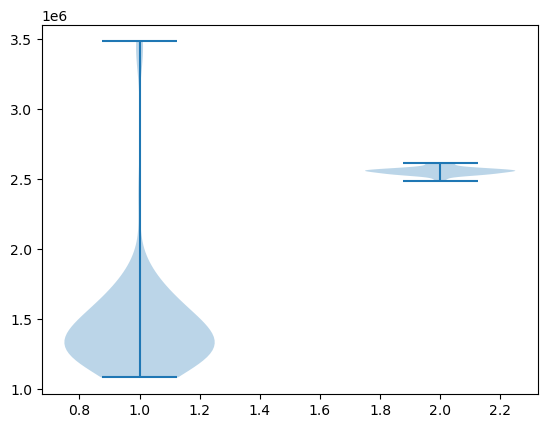

In [27]:
num_reps = 100
np.random.seed(1234)

tax_rev_lognorm = np.empty(num_reps)
tax_rev_pareto = np.empty(num_reps)

for i in range(num_reps):
    tax_rev_pareto[i] = tax_rev('pareto')
    tax_rev_lognorm[i] = tax_rev('lognorm')

fig, ax = plt.subplots()

data = tax_rev_pareto, tax_rev_lognorm

ax.violinplot(data)

plt.show()

Finally, let's print the means and standard deviations.

In [28]:
tax_rev_pareto.mean(), tax_rev_pareto.std()

(1458729.0546623734, 406089.3613661567)

In [29]:
tax_rev_lognorm.mean(), tax_rev_lognorm.std()

(2556174.8615230713, 25586.44456513965)

Looking at the output of the code, our main conclusion is that the Pareto
assumption leads to a lower mean and greater dispersion.

```{solution-end}
```

```{exercise}
:label: ht_ex_cauchy

The [characteristic function](https://en.wikipedia.org/wiki/Characteristic_function_%28probability_theory%29) of the Cauchy distribution is

$$
    \phi(t) = \mathbb E e^{itX} = \int e^{i t x} f(x) dx = e^{-|t|}
$$ (lln_cch)

Prove that the sample mean $\bar X_n$ of $n$ independent draws $X_1, \ldots,
X_n$ from the Cauchy distribution has the same characteristic function as
$X_1$.

(This means that the sample mean never converges.)

```

```{solution-start} ht_ex_cauchy
:class: dropdown
```

By independence, the characteristic function of the sample mean becomes

$$
\begin{aligned}
    \mathbb E e^{i t \bar X_n }
    & = \mathbb E \exp \left\{ i \frac{t}{n} \sum_{j=1}^n X_j \right\}
    \\
    & = \mathbb E \prod_{j=1}^n \exp \left\{ i \frac{t}{n} X_j \right\}
    \\
    & = \prod_{j=1}^n \mathbb E \exp \left\{ i \frac{t}{n} X_j \right\}
    = [\phi(t/n)]^n
\end{aligned}
$$

In view of {eq}`lln_cch`, this is just $e^{-|t|}$.

Thus, in the case of the Cauchy distribution, the sample mean itself has the very same Cauchy distribution, regardless of $n$!

```{solution-end}
```